In [1]:
# Import packages

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import wf_psf as wf
import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_mccd_psf_field as tf_mccd_psf_field
import wf_psf.tf_psf_field as tf_psf_field
import wf_psf.metrics as wf_metrics
import wf_psf.train_utils as wf_train_utils

import poppy as poppy

# Plot style & colormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.colormaps['Oranges_r'].resampled(128)
bottom = mpl.colormaps['Blues'].resampled(128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


In [2]:
args = {
    'dataset_folder': '/disk/xray0/tl3/repos/wf-studies/WFE_res/dataset/',
    #'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/more_stars/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_009_wfeRes_4096.npy',
    #'train_dataset_file': 'train_Euclid_res_3000_TrainStars_id_008_wfeRes_128.npy',
    'test_dataset_file': 'test_Euclid_res_id_009_wfeRes_4096.npy',
    #'test_dataset_file': 'test_Euclid_res_id_008_wfeRes_128.npy',
    'n_zernikes': 15,
    'pupil_diameter': 256,
    #'pupil_diameter': 128,
    'n_bins_lda':20,
    #'n_bins_lda':8,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 5,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,
    'chkp_save_path':'/disk/xray0/tl3/repos/wf-studies/WFE_res/wf-outputs/chkp/chkp_callback_poly_wfe_study_id009_256_benchmark_bis_1_cycle2',
    #'chkp_save_path':'../../more_stars/wf-outputs/chkp/3000_stars/chkp_callback_poly_full_poly_3000_stars_cycle2',
}

In [3]:
## Prepare the inputs
# Generate Zernike maps
zernikes = wf_utils.zernike_generator(
    n_zernikes=args['n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it, :, :] = zernikes[it]
np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)
print('Zernike cube:')
print(tf_zernike_cube.shape)

# Generate ground truth Zernike maps
zernikes_gt = wf_utils.zernike_generator(
    n_zernikes=args['gt_n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube_gt = np.zeros((len(zernikes_gt), zernikes_gt[0].shape[0], zernikes_gt[0].shape[1]))
for it in range(len(zernikes_gt)):
    np_zernike_cube_gt[it, :, :] = zernikes_gt[it]
np_zernike_cube_gt[np.isnan(np_zernike_cube_gt)] = 0
tf_zernike_cube_gt = tf.convert_to_tensor(np_zernike_cube_gt, dtype=tf.float32)
print('Ground truth Zernike cube:')
print(tf_zernike_cube_gt.shape)

2023-06-05 14:28:28.378737: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 14:28:28.837468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 32383 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


Zernike cube:
(15, 256, 256)
Ground truth Zernike cube:
(45, 256, 256)


In [4]:
## Generate initializations
# Prepare np input
simPSF_np = SimPSFToolkit(
    zernikes,
    max_order=args['n_zernikes'],
    pupil_diameter=args['pupil_diameter'],
    output_dim=args['output_dim'],
    oversampling_rate=args['oversampling_rate'],
    output_Q=args['output_q']
)
simPSF_np.gen_random_Z_coeffs(max_order=args['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)
# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args['pupil_diameter'], N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)

In [5]:
obscurations.shape

(256, 256)

In [6]:
tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
            zernike_maps=tf_zernike_cube,
            obscurations=tf_obscurations,
            batch_size=args['batch_size'],
            output_Q=args['output_q'],
            d_max_nonparam=args['d_max_nonparam'],
            l2_param=args['l2_param'],
            output_dim=args['output_dim'],
            n_zernikes=args['n_zernikes'],
            d_max=args['d_max'],
            x_lims=args['x_lims'],
            y_lims=args['y_lims']
        )


weights_paths = args['chkp_save_path']

# Load the model's weights
tf_semiparam_field.load_weights(weights_paths)

In [7]:
tf_semiparam_field.tf_np_poly_opd.S_mat.shape

TensorShape([21, 256, 256])

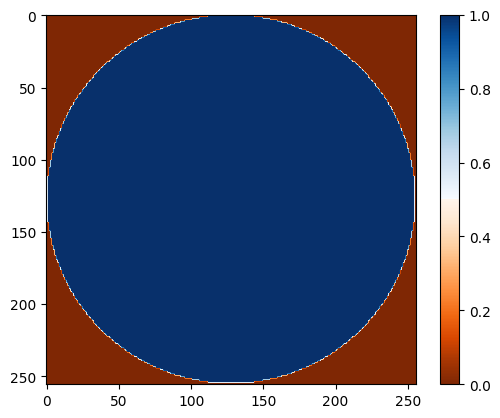

In [8]:
plt.figure()
plt.imshow(tf_zernike_cube[0,:,:], cmap=newcmp)
plt.colorbar()
plt.show()

# New projection method

In [9]:
def decompose_obscured_opd_basis(opd, obscurations, zk_basis, iters=20):
    opd_zeros = np.nan_to_num(opd, copy=True, nan=0.0)
    obscurations_zeros = np.nan_to_num(obscurations, copy=True, nan=0.0)
    ngood = obscurations.sum()

    zk_basis_zeros = np.nan_to_num(zk_basis, copy=True, nan=0.0)

    obsc_coeffs = np.zeros(zk_basis_zeros.shape[0])
    new_coeffs = np.zeros(zk_basis_zeros.shape[0])

    for count in range(iters):
        for i, b in enumerate(zk_basis_zeros):
            this_coeff = (opd_zeros * b).sum() / ngood
            new_coeffs[i] = this_coeff

        for i, b in enumerate(zk_basis_zeros):
            opd_zeros -= (new_coeffs[i] * b) * obscurations_zeros

        obsc_coeffs += new_coeffs
        new_coeffs = np.zeros(zk_basis_zeros.shape[0])

    return obsc_coeffs


def tf_decompose_obscured_opd_basis(tf_opd, tf_obscurations, tf_zk_basis, n_zernike, iters=20):
    """ Decompose obscured OPD into a basis using an iterative algorithm.
    
    Tensorflow implementation.

    Parameters
    ----------
    tf_opd: tf.Tensor(opd_dim, opd_dim)  
        Input OPD that requires to be decomposed on `tf_zk_basis`.
    tf_obscurations: tf.Tensor(opd_dim, opd_dim)
        Tensor with the obscuration map.
    tf_zk_basis: Tensor(n_batch, opd_dim, opd_dim)
        Zernike polynomial maps.
    n_zernike: int
        Number of Zernike polynomials to project on.
    iters: int
        Number of iterations of the algorithm.

    Returns
    -------
    obsc_coeffs: np.ndarray(n_zernike)
        Array with projected Zernike coefficients

    Raises
    ------
        ValueError: If `n_zernike` is bigger than tf_zk_basis.shape[0]. 

    """
    if n_zernike > tf_zk_basis.shape[0]:
        raise ValueError('Cannot project as n_zernike is bigger than the zernike elements in the provided basis tf_zk_basis.')
    # Clone input OPD
    input_tf_opd = tf.identity(tf_opd)
    # Clone obscurations and project
    input_tf_obscurations = tf.math.real(tf.identity(tf_obscurations))
    # Compute normalisation factor
    ngood = tf.math.reduce_sum(input_tf_obscurations,
        axis=None,
        keepdims=False
    ).numpy()

    obsc_coeffs = np.zeros(n_zernike)
    new_coeffs = np.zeros(n_zernike)

    for count in range(iters):
        for i, b in enumerate(tf_zk_basis):
            this_coeff = tf.math.reduce_sum(
                tf.math.multiply(input_tf_opd, b), axis=None, keepdims=False
            ).numpy() / ngood
            new_coeffs[i] = this_coeff

        for i, b in enumerate(tf_zk_basis):
            input_tf_opd = input_tf_opd - tf.math.multiply(
                new_coeffs[i] * b,
                input_tf_obscurations
            )

        obsc_coeffs += new_coeffs
        new_coeffs = np.zeros(n_zernike)

    return obsc_coeffs


# New implementation

In [14]:
# To compare
# new_C_poly
# S_new

model = tf_semiparam_field


In [15]:

# Compute Zernike norm for projections
n_pix_zernike = wf.utils.PI_zernikes(tf_zernike_cube[0, :, :], tf_zernike_cube[0, :, :])
# Multiply Alpha matrix with DD features matrix S
inter_res_v2 = tf.tensordot(
    model.tf_np_poly_opd.alpha_mat[:model.tf_poly_Z_field.coeff_mat.shape[1], :],
    model.tf_np_poly_opd.S_mat,
    axes=1
)
# Project over first n_z Zernikes
delta_C_poly = tf.constant(
    np.array([[
        wf.utils.PI_zernikes(tf_zernike_cube[i, :, :], inter_res_v2[j, :, :], n_pix_zernike)
        for j in range(model.tf_poly_Z_field.coeff_mat.shape[1])
    ]
                for i in range(model.n_zernikes)]),
    dtype=tf.float32
)
old_C_poly = model.tf_poly_Z_field.coeff_mat
# Corrected parametric coeff matrix
new_C_poly = old_C_poly + delta_C_poly
# model.assign_coeff_matrix(new_C_poly)

# Remove extracted features from non-parametric model
# Mix DD features with matrix alpha
S_tilde = tf.tensordot(
    model.tf_np_poly_opd.alpha_mat,
    model.tf_np_poly_opd.S_mat,
    axes=1
)
# Get beta tilde as the proyection of the first n_param_poly_terms (6 for d_max=2) onto the first n_zernikes.
beta_tilde_inner = np.array([[
    wf.utils.PI_zernikes(
        tf_zernike_cube[j, :, :],
        S_tilde_slice,
        n_pix_zernike
    ) for j in range(model.n_zernikes)
] for S_tilde_slice in S_tilde[:model.tf_poly_Z_field.coeff_mat.shape[1], :, :]])

# Only pad in the firs dimention so we get a matrix of size (d_max_nonparam_terms)x(n_zernikes)  --> 21x15 or 21x45.
beta_tilde = np.pad(
    beta_tilde_inner,
    [(0, S_tilde.shape[0] - beta_tilde_inner.shape[0]), (0, 0)],
    mode='constant'
)

# Unmix beta tilde with the inverse of alpha
beta = tf.constant(
    np.linalg.inv(model.tf_np_poly_opd.alpha_mat) @ beta_tilde, dtype=tf.float32
)
# Get the projection for the unmixed features

# Now since beta.shape[1]=n_zernikes we can take the whole beta matrix.
S_mat_projected = tf.tensordot(beta, tf_zernike_cube, axes=[1, 0])

# Subtract the projection from the DD features
S_new = model.tf_np_poly_opd.S_mat - S_mat_projected
# model.assign_S_mat(S_new)


2023-06-05 14:28:49.779653: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [16]:
# Compute Zernike norm for projections
# n_pix_zernike = wf.utils.PI_zernikes(tf_zernike_cube[0, :, :], tf_zernike_cube[0, :, :])
# Multiply Alpha matrix with DD features matrix S
inter_res_v2 = tf.tensordot(
    model.tf_np_poly_opd.alpha_mat[:model.tf_poly_Z_field.coeff_mat.shape[1], :],
    model.tf_np_poly_opd.S_mat,
    axes=1
)
# Project over first n_z Zernikes
delta_C_poly = tf.constant(
    np.transpose(np.array([
        tf_decompose_obscured_opd_basis(
            tf_opd=inter_res_v2[j,:,:],
            tf_obscurations=tf_obscurations,
            tf_zk_basis=tf_zernike_cube,
            n_zernike=model.n_zernikes,
            iters=40
        ) for j in range(model.tf_poly_Z_field.coeff_mat.shape[1])
    ])),
    dtype=tf.float32
)

old_C_poly = model.tf_poly_Z_field.coeff_mat
# Corrected parametric coeff matrix
new_C_poly_v2 = old_C_poly + delta_C_poly
# model.assign_coeff_matrix(new_C_poly)

# Remove extracted features from non-parametric model
# Mix DD features with matrix alpha
S_tilde = tf.tensordot(
    model.tf_np_poly_opd.alpha_mat,
    model.tf_np_poly_opd.S_mat,
    axes=1
)
# Get beta tilde as the proyection of the first n_param_poly_terms (6 for d_max=2) onto the first n_zernikes.
beta_tilde_inner = np.array([
    tf_decompose_obscured_opd_basis(
        tf_opd=S_tilde_slice,
        tf_obscurations=tf_obscurations,
        tf_zk_basis=tf_zernike_cube,
        n_zernike=model.n_zernikes,
        iters=40
    ) for S_tilde_slice in S_tilde[:model.tf_poly_Z_field.coeff_mat.shape[1], :, :]
])

# Only pad in the firs dimention so we get a matrix of size (d_max_nonparam_terms)x(n_zernikes)  --> 21x15 or 21x45.
beta_tilde = np.pad(
    beta_tilde_inner,
    [(0, S_tilde.shape[0] - beta_tilde_inner.shape[0]), (0, 0)],
    mode='constant'
)

# Unmix beta tilde with the inverse of alpha
beta = tf.constant(
    np.linalg.inv(model.tf_np_poly_opd.alpha_mat) @ beta_tilde, dtype=tf.float32
)
# Get the projection for the unmixed features

# Now since beta.shape[1]=n_zernikes we can take the whole beta matrix.
S_mat_projected = tf.tensordot(beta, tf_zernike_cube, axes=[1, 0])

# Subtract the projection from the DD features
S_new_v2 = model.tf_np_poly_opd.S_mat - S_mat_projected
# model.assign_S_mat(S_new)



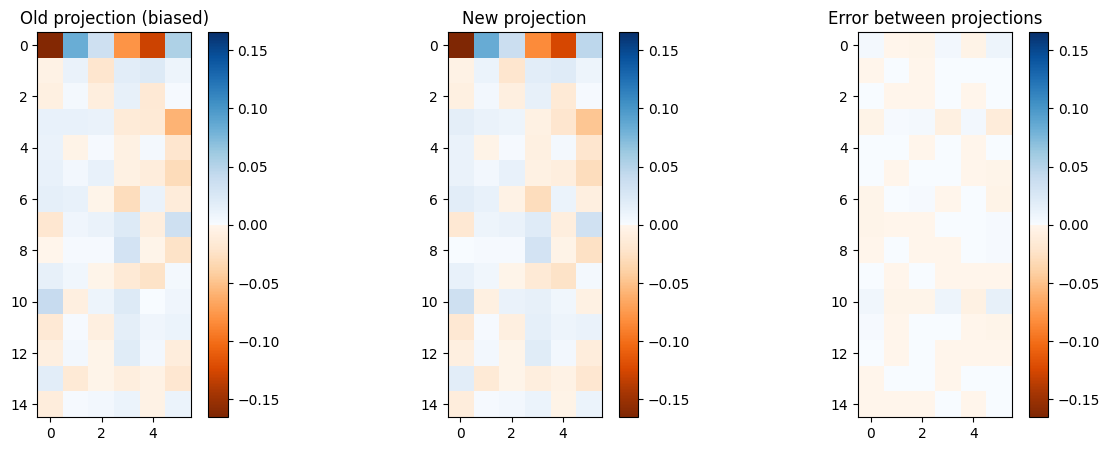

In [17]:


plt.figure(figsize=(15,5))


# np_inter_res_v2 = inter_res_v2.numpy()
vmax = np.max([np.abs(new_C_poly.numpy()), np.abs(new_C_poly_v2.numpy()), np.abs((new_C_poly - new_C_poly_v2).numpy())])

# vmax = np.max(np.abs(new_C_poly.numpy()))
plt.subplot(131)
plt.imshow(new_C_poly, cmap=newcmp, vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.title('Old projection (biased)')

# vmax = np.max(np.abs(new_C_poly_v2.numpy()))
plt.subplot(132)
plt.imshow(new_C_poly_v2, cmap=newcmp, vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.title('New projection')

# vmax = np.max(np.abs((new_C_poly - new_C_poly_v2).numpy()))
plt.subplot(133)
plt.imshow((new_C_poly - new_C_poly_v2), cmap=newcmp, vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.title('Error between projections')

plt.show()




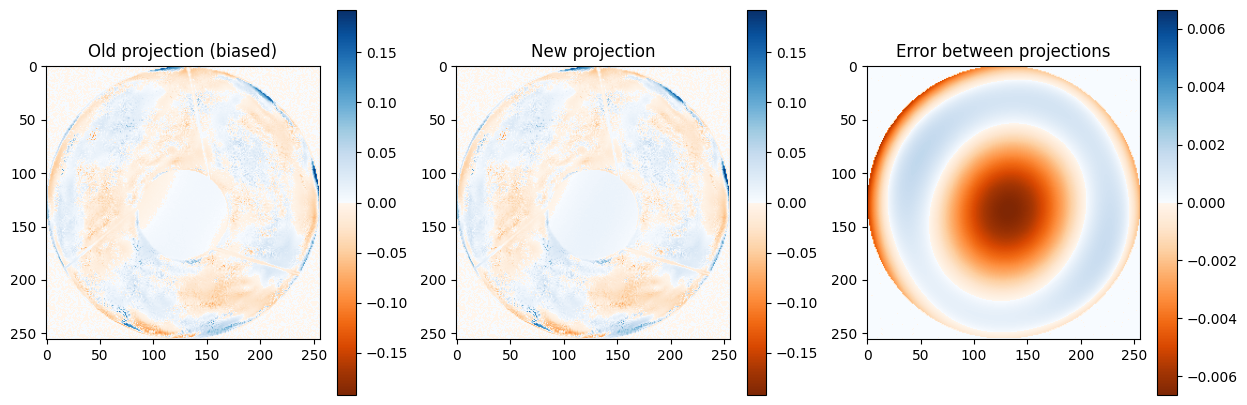

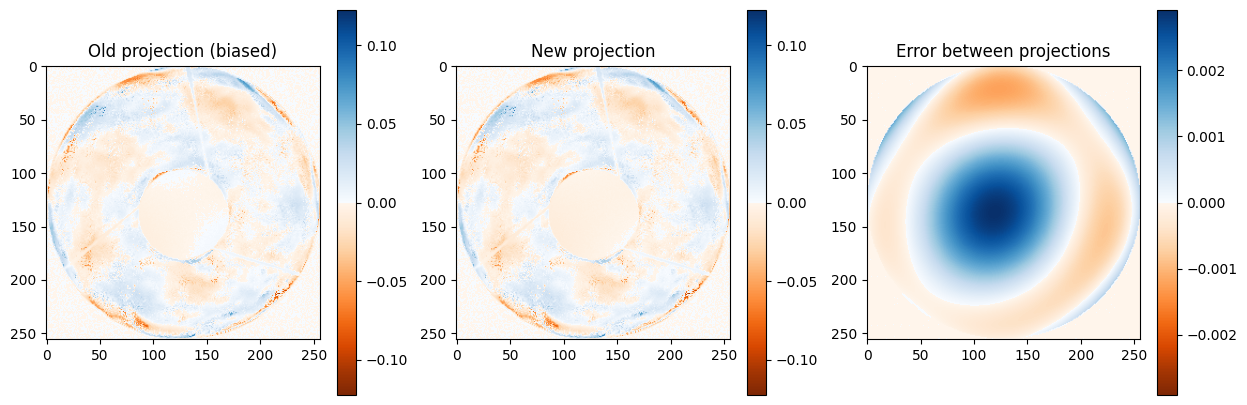

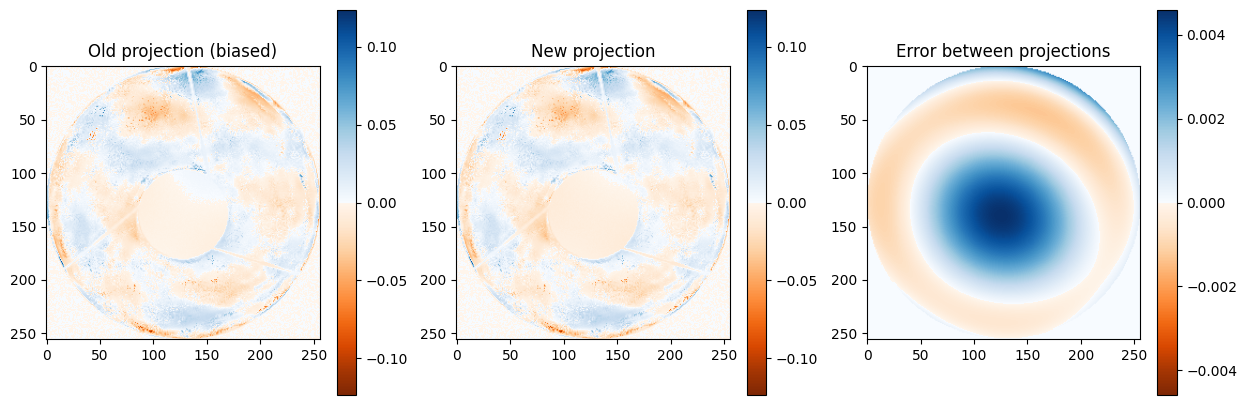

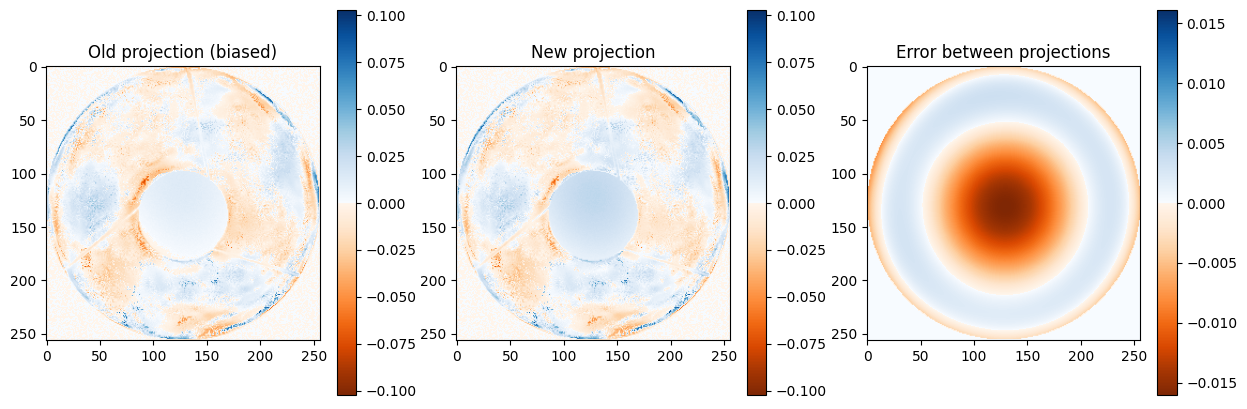

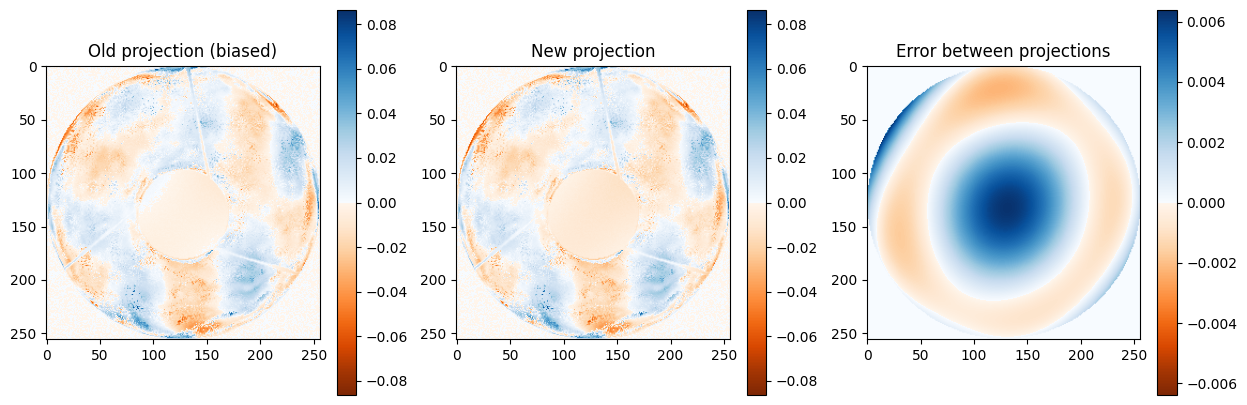

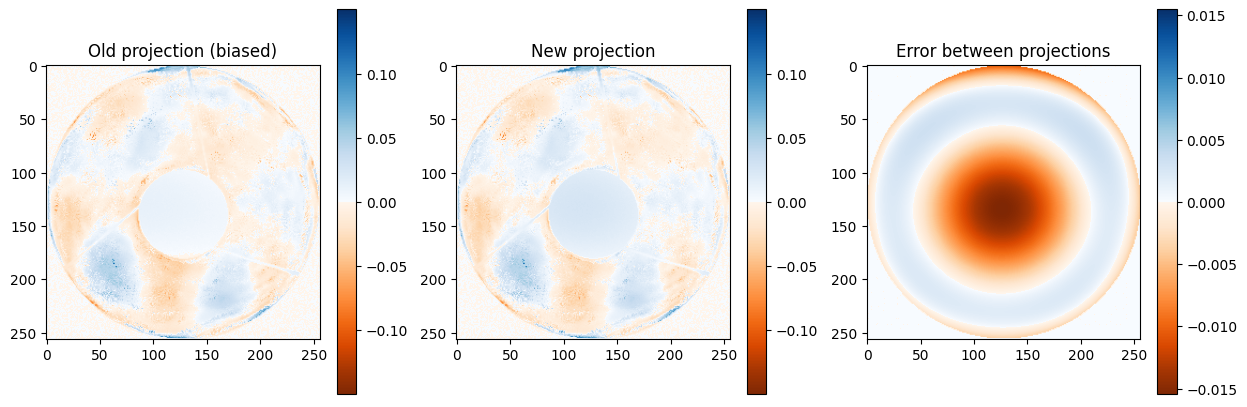

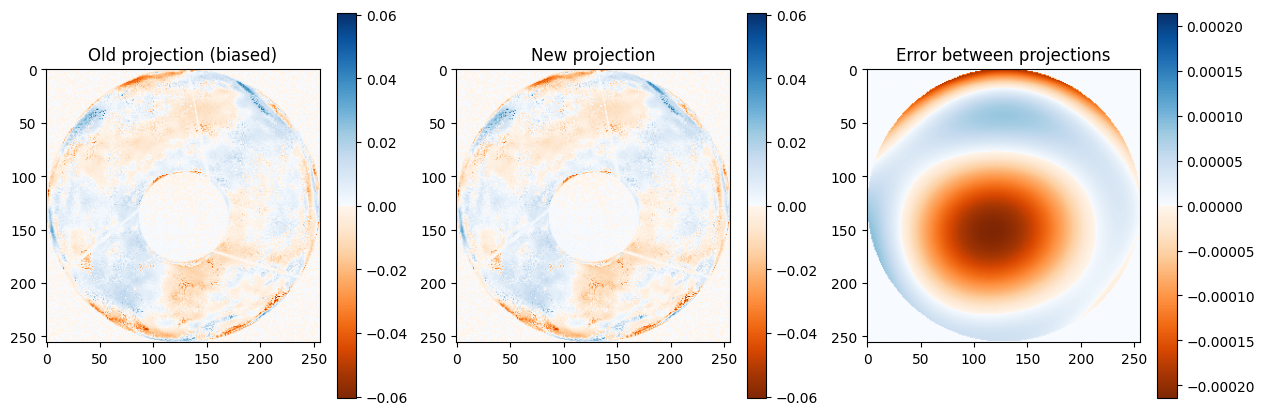

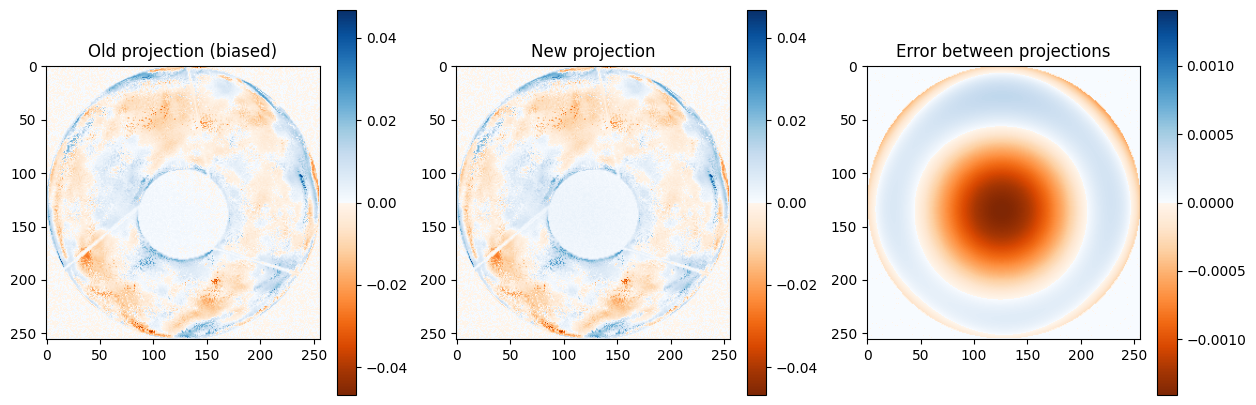

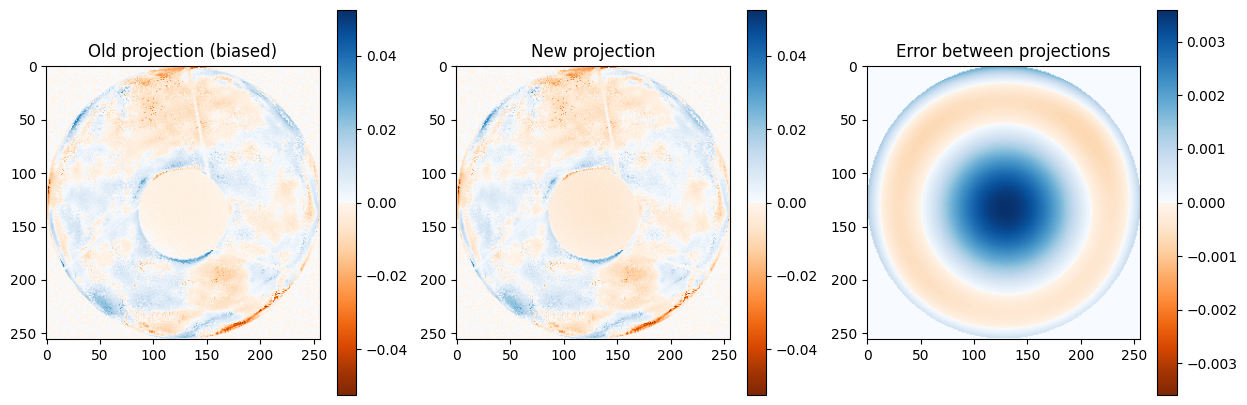

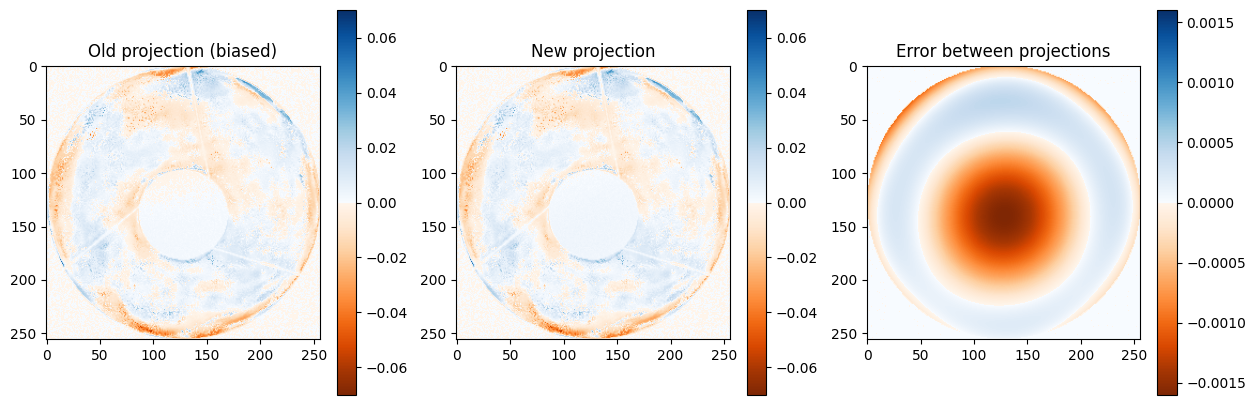

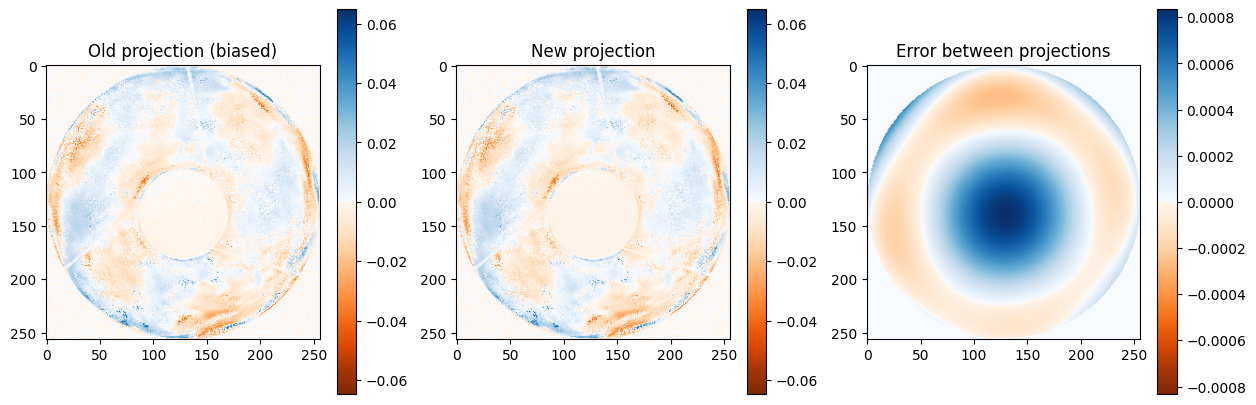

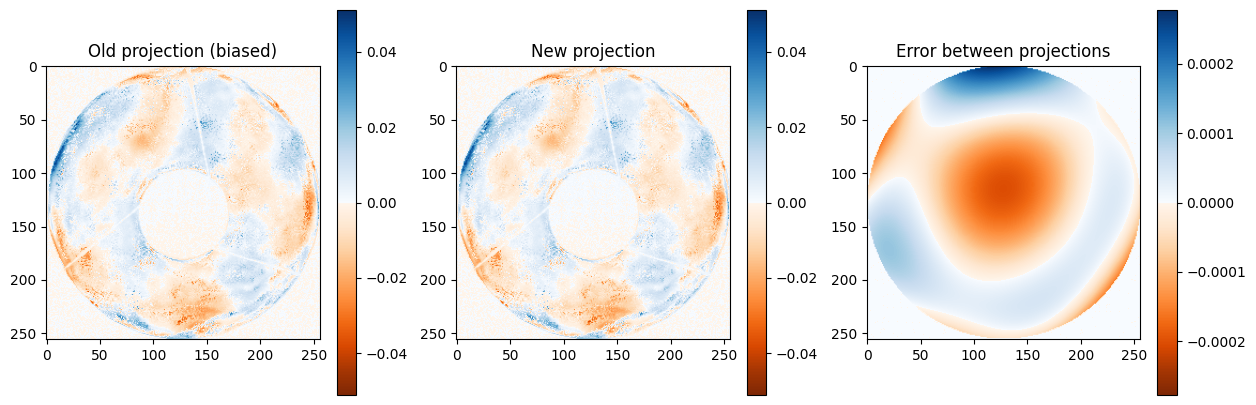

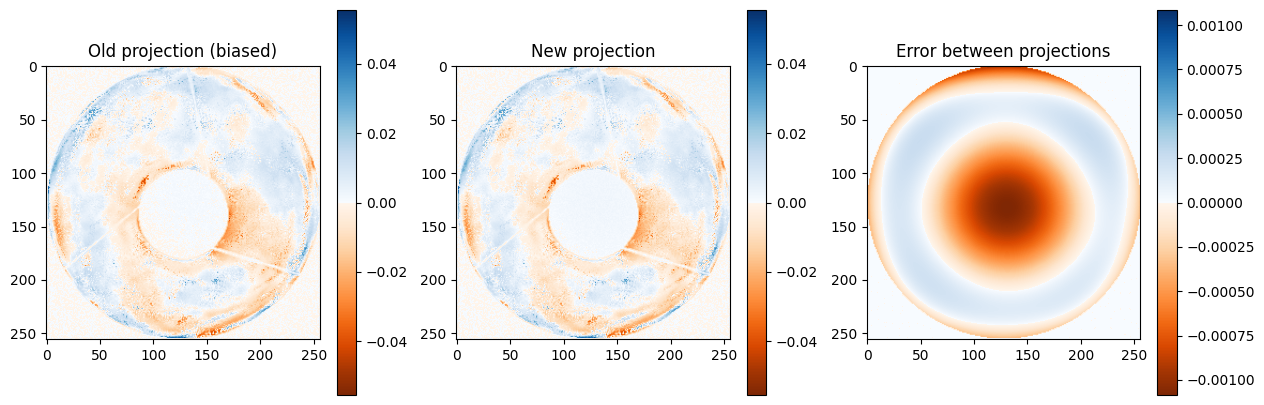

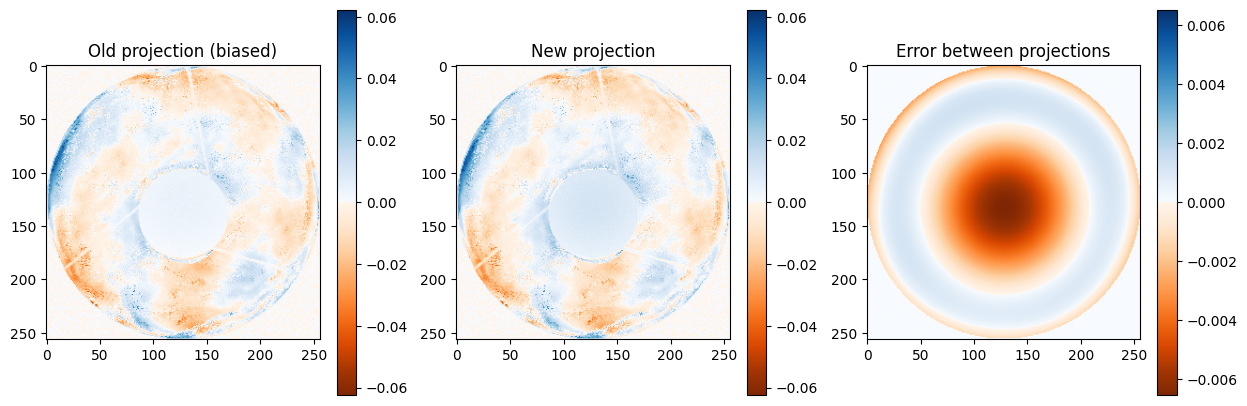

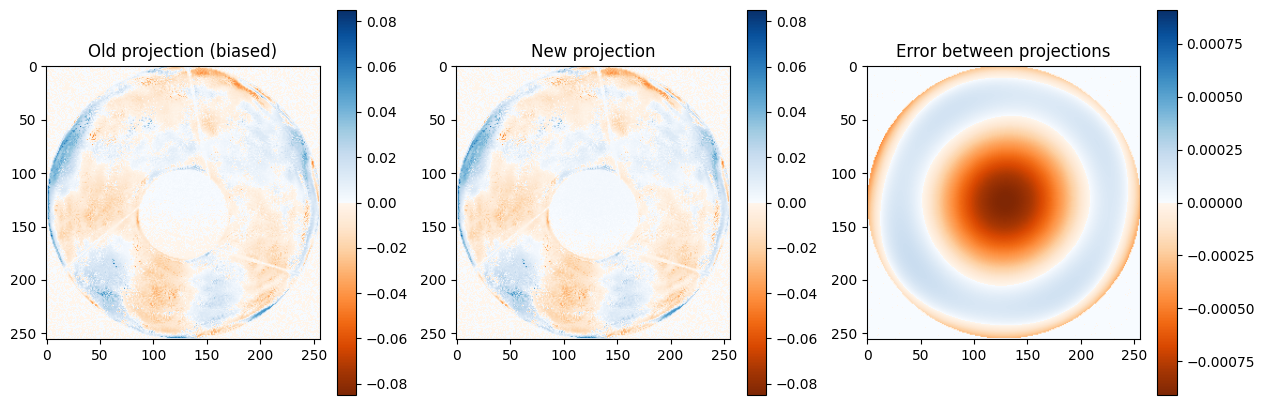

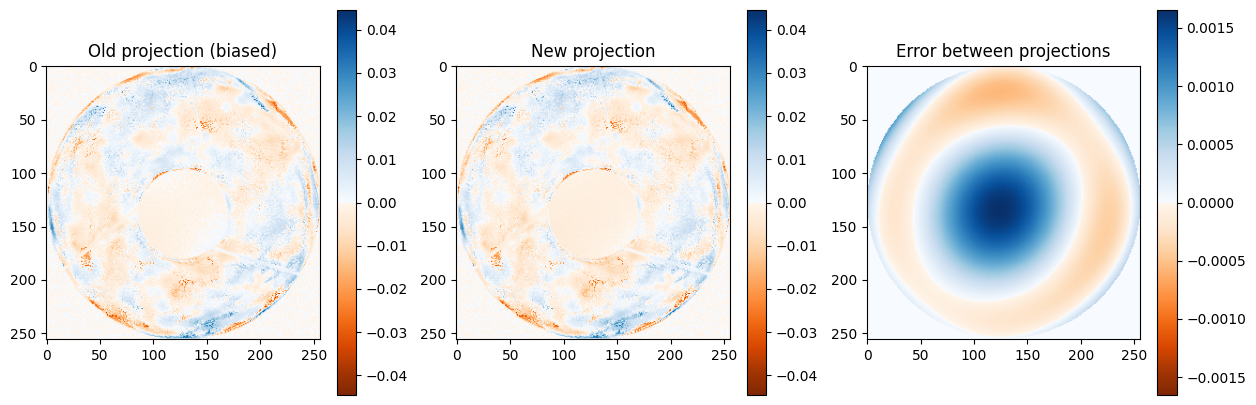

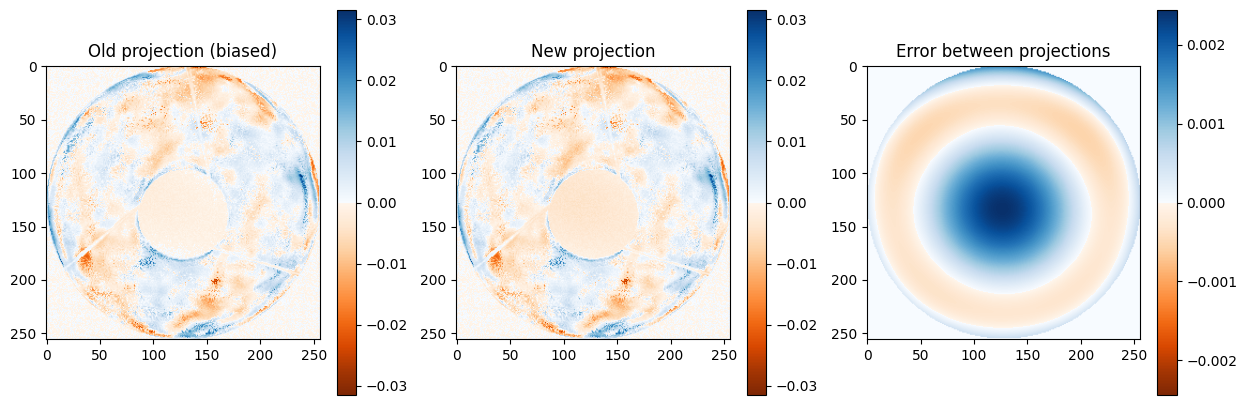

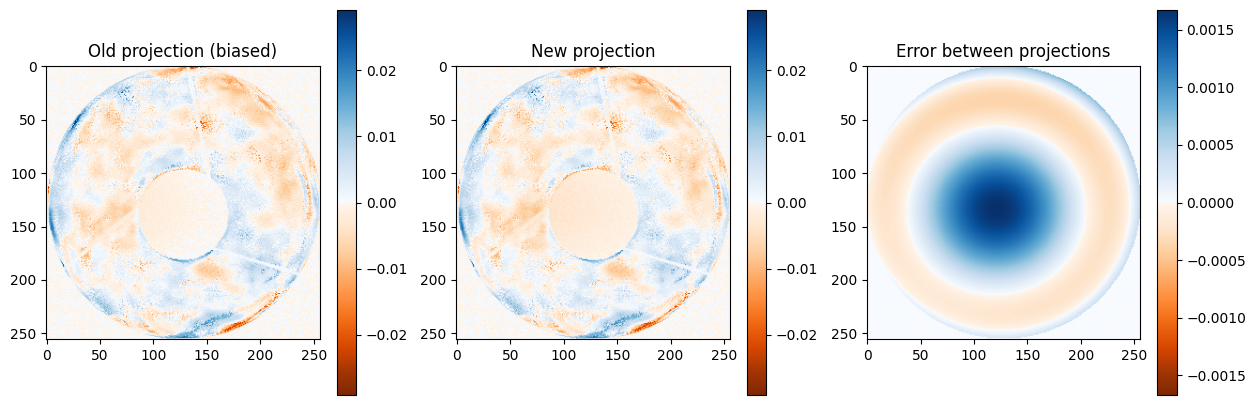

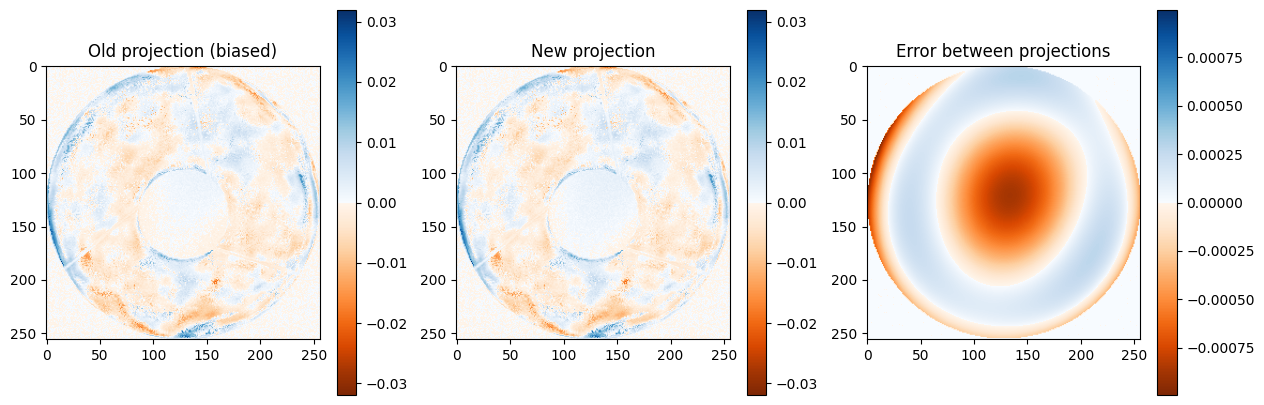

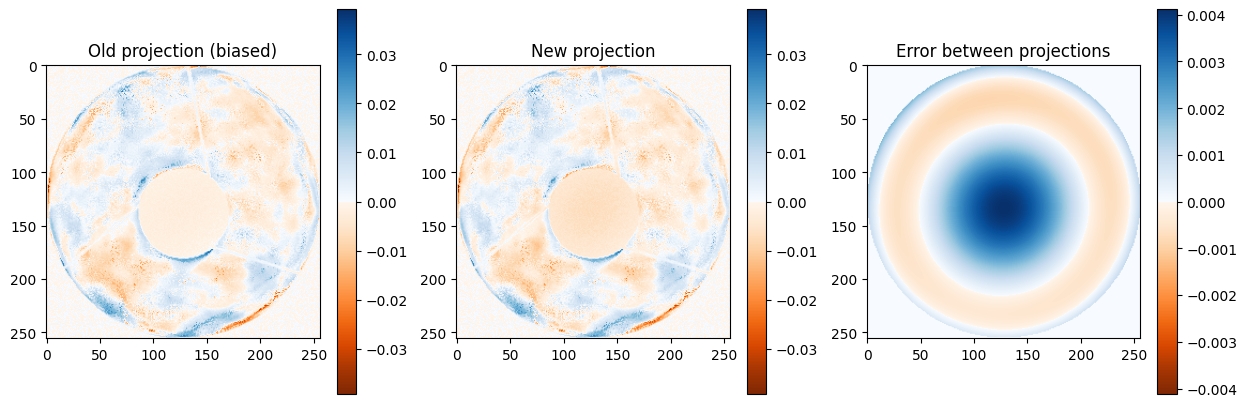

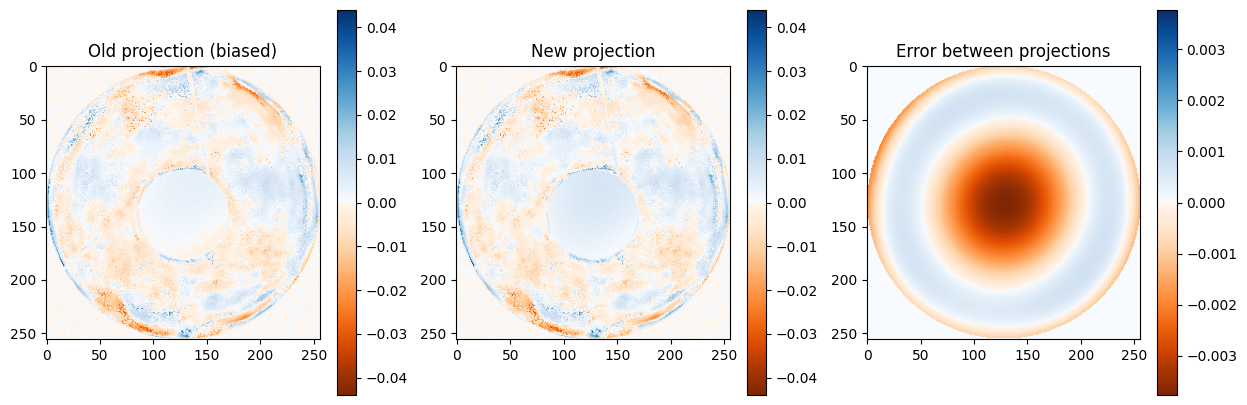

In [18]:

for it in range(S_new.shape[0]):

    plt.figure(figsize=(15,5))

    # np_inter_res_v2 = inter_res_v2.numpy()
    vmax = np.max([
        np.abs(S_new[it].numpy()),
        np.abs(S_new_v2[it].numpy()),
        np.abs((S_new[it] - S_new_v2[it]).numpy())
    ])

    # vmax = np.max(np.abs(new_C_poly.numpy()))
    plt.subplot(131)
    plt.imshow(S_new[it], cmap=newcmp, vmax=vmax, vmin=-vmax)
    plt.title('Old projection (biased)')
    plt.colorbar()

    # vmax = np.max(np.abs(new_C_poly_v2.numpy()))
    plt.subplot(132)
    plt.imshow(S_new_v2[it], cmap=newcmp, vmax=vmax, vmin=-vmax)
    plt.title('New projection')
    plt.colorbar()

    vmax = np.max(np.abs((S_new[it] - S_new_v2[it]).numpy()))
    plt.subplot(133)
    plt.imshow((S_new[it] - S_new_v2[it]), cmap=newcmp, vmax=vmax, vmin=-vmax)
    plt.title('Error between projections')
    plt.colorbar()

    plt.show()



## Development

In [19]:
model = tf_semiparam_field

In [20]:
n_pix_zernike = wf.utils.PI_zernikes(tf_zernike_cube[0, :, :], tf_zernike_cube[0, :, :])
# Multiply Alpha matrix with DD features matrix S
inter_res_v2 = tf.tensordot(
    model.tf_np_poly_opd.alpha_mat[:model.tf_poly_Z_field.coeff_mat.shape[1], :],
    model.tf_np_poly_opd.S_mat,
    axes=1
)

In [21]:
# model.tf_poly_Z_field.coeff_mat.shape -> [n_zernike, n_poly(d_max)]
# -> [15, 6]
# model.tf_np_poly_opd.S_mat.shape -> [n_poly(d_max_nonparam), wfe_res, wfe_res]
# -> [21, 256, 256]
# model.tf_np_poly_opd.alpha_mat.shape -> [n_poly(d_max_nonparam), n_poly(d_max_nonparam)]
# -> [21, 21]
# inter_res_v2.shape -> [n_poly(d_max), wfe_res, wfe_res]
#  -> [6, 256, 256]

# delta_C_poly -> [n_zernike, n_poly(d_max)]
# -> [15, 6]


In [22]:
# Project over first n_z Zernikes
delta_C_poly = tf.constant(
    np.array([[
        wf.utils.PI_zernikes(
            tf_zernike_cube[i, :, :],
            inter_res_v2[j, :, :],
            n_pix_zernike
        )
        for j in range(model.tf_poly_Z_field.coeff_mat.shape[1])
    ] for i in range(model.n_zernikes)]),
    dtype=tf.float32
)


In [23]:
old_C_poly = model.tf_poly_Z_field.coeff_mat
# Corrected parametric coeff matrix
new_C_poly = old_C_poly + delta_C_poly
model.assign_coeff_matrix(new_C_poly)

In [24]:
# Remove extracted features from non-parametric model
# Mix DD features with matrix alpha
S_tilde = tf.tensordot(
    model.tf_np_poly_opd.alpha_mat,
    model.tf_np_poly_opd.S_mat,
    axes=1
)


In [25]:
# Get beta tilde as the proyection of the first n_param_poly_terms (6 for d_max=2) onto the first n_zernikes.
beta_tilde_inner = np.array([[
    wf.utils.PI_zernikes(
        tf_zernike_cube[j, :, :],
        S_tilde_slice,
        n_pix_zernike
    ) for j in range(model.n_zernikes)
] for S_tilde_slice in S_tilde[:model.tf_poly_Z_field.coeff_mat.shape[1], :, :]])


In [26]:
beta_tilde_inner.shape

(6, 15)

In [27]:

new_beta_tilde_inner = np.array([
    tf_decompose_obscured_opd_basis(
        tf_opd=S_tilde_slice,
        tf_obscurations=tf_obscurations,
        tf_zk_basis=tf_zernike_cube,
        n_zernike=model.n_zernikes,
        iters=40
    ) for S_tilde_slice in S_tilde[:model.tf_poly_Z_field.coeff_mat.shape[1], :, :]
])



In [28]:
new_beta_tilde_inner.shape

(6, 15)

In [29]:



new_delta_C_poly = tf.constant(
    np.transpose(np.array([
        tf_decompose_obscured_opd_basis(
            tf_opd=inter_res_v2[j,:,:],
            tf_obscurations=tf_obscurations,
            tf_zk_basis=tf_zernike_cube,
            n_zernike=model.n_zernikes,
            iters=40
        ) for j in range(model.tf_poly_Z_field.coeff_mat.shape[1])
    ])),
    dtype=tf.float32
)



In [30]:
new_delta_C_poly.shape

TensorShape([15, 6])

In [31]:
delta_C_poly.shape

TensorShape([15, 6])

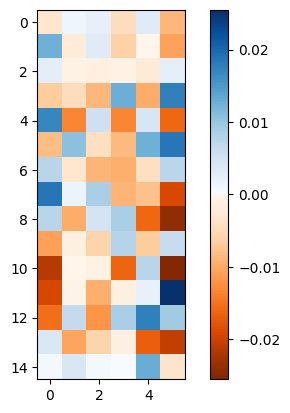

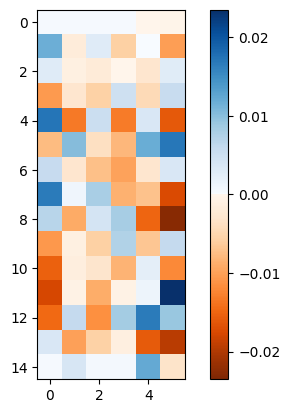

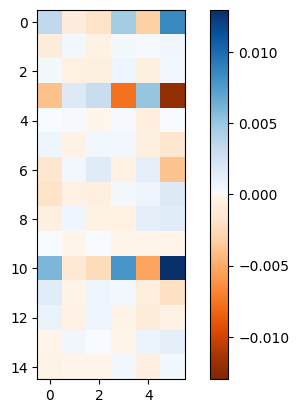

In [32]:
it = 1
# np_inter_res_v2 = inter_res_v2.numpy()

vmax = np.max(np.abs(new_delta_C_poly.numpy()))
plt.figure()
plt.imshow(new_delta_C_poly, cmap=newcmp, vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.show()

vmax = np.max(np.abs(delta_C_poly.numpy()))
plt.figure()
plt.imshow(delta_C_poly, cmap=newcmp, vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.show()

vmax = np.max(np.abs((delta_C_poly-new_delta_C_poly).numpy()))
plt.figure()
plt.imshow((delta_C_poly-new_delta_C_poly), cmap=newcmp, vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.show()


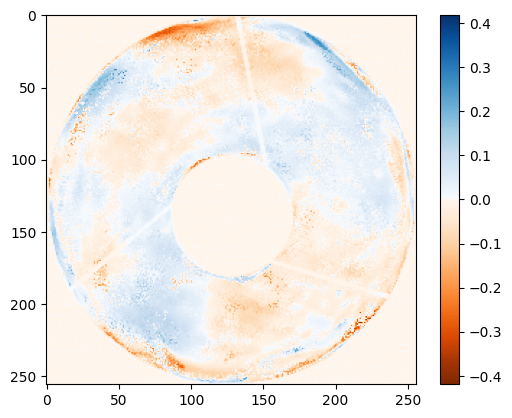

In [33]:
it = 1
np_inter_res_v2 = inter_res_v2.numpy()

vmax = np.max(np.abs(np_inter_res_v2[it,:,:]))
plt.figure()
plt.imshow(np_inter_res_v2[it,:,:]*obscurations, cmap=newcmp, vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.show()

